# **1. Preparação e organização do notebook**

## 1.1 Cabeçalho

In [107]:
# ─────────────────────────────────────────────────────────────────────────────
# Trabalho Computacional 2 — Redes Neurais Profundas
# Aluno: Deivid Ribeiro
# Data de entrega: 02 / 07 / 2025
#
# Sumário
#   1. Preparação e organização do notebook
#   2. Geração e pré-processamento dos dados
#   3. Definição dos modelos
#   4. Treinamento
#   5. Avaliação e métricas
#   6. Visualizações obrigatórias
#   7. Conclusões e exportação
# ─────────────────────────────────────────────────────────────────────────────

## 1.2 Bibliotecas e configurações

In [108]:
# ─── Importações principais ──────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from statsmodels.graphics.gofplots import qqplot_2samples
from scipy.stats import ks_2samp
import warnings

# ─── Configurações globais ───────────────────────────────────────────────────
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# ─── Dispositivo: GPU (se disponível) ────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)

# ─── Seed para reprodutibilidade ─────────────────────────────────────────────
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Dispositivo: cpu


# **2. Geração e preparação do dataset**

## 2.1 Geração da série de Mackey-Glass

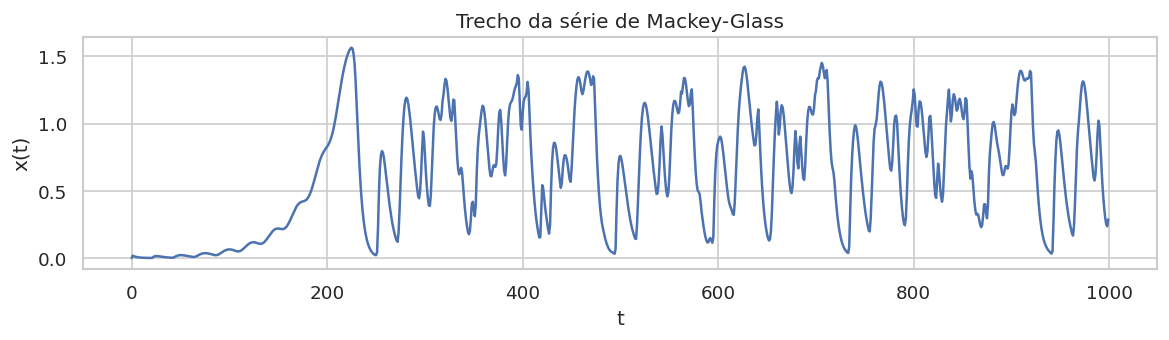

In [109]:
# ─── Função Mackey-Glass ─────────────────────────────────────────────────────
def mackey_glass_enunciado(N=10000, beta=0.4, gamma=0.2, n=18, tau=20):
    x = [0] * tau
    x.append(1)
    for _ in range(N):
        xt = x[-1] + (beta * x[-tau] / (1 + x[-tau]**n)) - gamma * x[-1]
        x.append(xt)
    return np.array(x[tau+1:])  # descarta os iniciais, como no enunciado

# ─── Geração e visualização inicial ──────────────────────────────────────────
serie = mackey_glass(N=10000, beta=0.4, gamma=0.2, n=18, tau=20)

plt.figure(figsize=(10, 3))
plt.plot(serie[:1000])
plt.title("Trecho da série de Mackey-Glass")
plt.xlabel("t")
plt.ylabel("x(t)")
plt.tight_layout()
plt.show()


## 2.2 Normalização da série e divisão treino/teste

In [110]:
# ─── Normalização da série ───────────────────────────────────────────────────
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
serie_norm = scaler.fit_transform(serie.reshape(-1, 1)).flatten()

# ─── Separação em treino e teste ─────────────────────────────────────────────
train_frac = 0.9 #90% conforme solicitado
split_idx = int(len(serie_norm) * train_frac)

train_series = serie_norm[:split_idx]
test_series = serie_norm[split_idx:]

print(f"Tamanho da série: {len(serie_norm)}")
print(f"Treino: {len(train_series)} amostras")
print(f"Teste:  {len(test_series)} amostras")


Tamanho da série: 10001
Treino: 9000 amostras
Teste:  1001 amostras


## 2.3 Criação das janelas de entrada

In [111]:
# ─── Parâmetros da janela temporal ───────────────────────────────────────────
SEQ_LEN = 25  # número de passos no passado usados para prever o próximo

def create_sequences(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i + seq_len])
        y.append(series[i + seq_len])
    return np.array(X), np.array(y)

# ─── Construção das janelas ──────────────────────────────────────────────────
X_train, y_train = create_sequences(train_series, SEQ_LEN)
X_test,  y_test  = create_sequences(test_series,  SEQ_LEN)

# ─── Conversão para tensores PyTorch ─────────────────────────────────────────
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).to(device)  # shape: (B, SEQ, 1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)

X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).to(device)

print("Shape X_train:", X_train.shape)
print("Shape y_train:", y_train.shape)
print("Shape X_test: ", X_test.shape)
print("Shape y_test: ", y_test.shape)

Shape X_train: torch.Size([8975, 25, 1])
Shape y_train: torch.Size([8975, 1])
Shape X_test:  torch.Size([976, 25, 1])
Shape y_test:  torch.Size([976, 1])


# **3. Definição dos modelos**

## 3.1 Modelo 1: MLP

In [112]:
class MLP(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(seq_len, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

## 3.2 Modelo 2: LSTM

In [113]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # usa o último hidden state

## 3.3 Modelo 3: GRU

In [114]:
class GRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

# **4. Treinamento**

## 4.1 Função de treino

In [115]:
def train_model(model, X_train, y_train, X_test, y_test,
                epochs=200, lr=1e-3, verbose=True):

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    hist_train, hist_test = [], []

    for epoch in range(1, epochs + 1):
        # Fase de treino
        model.train()
        optimizer.zero_grad()
        pred_train = model(X_train)
        loss_train = criterion(pred_train, y_train)
        loss_train.backward()
        optimizer.step()

        # Fase de validação
        model.eval()
        with torch.no_grad():
            pred_test = model(X_test)
            loss_test = criterion(pred_test, y_test)

        # Registro dos históricos
        hist_train.append(loss_train.item())
        hist_test.append(loss_test.item())

        # Impressão opcional
        if verbose:
            print(f"Época {epoch:3d} | MSE treino: {loss_train.item():.4f} | teste: {loss_test.item():.4f}")

    return model, hist_train, hist_test, pred_test.cpu().numpy()


## 4.2 Treinamento dos modelos

In [116]:
# ─── Parâmetros ──────────────────────────────────────────────────────────────
EPOCHS = 200
LR = 1e-3

# ─── Treinamento do MLP ──────────────────────────────────────────────────────
print("\nTreinando modelo: MLP")
mlp = MLP(seq_len=SEQ_LEN)
mlp, hist_mlp_tr, hist_mlp_te, preds_mlp = train_model(
    mlp, X_train, y_train, X_test, y_test, epochs=EPOCHS, lr=LR
)

# ─── Treinamento do LSTM ─────────────────────────────────────────────────────
print("\nTreinando modelo: LSTM")
lstm = LSTM(input_size=1, hidden_size=64)
lstm, hist_lstm_tr, hist_lstm_te, preds_lstm = train_model(
    lstm, X_train, y_train, X_test, y_test, epochs=EPOCHS, lr=LR
)

# ─── Treinamento do GRU ──────────────────────────────────────────────────────
print("\nTreinando modelo: GRU")
gru = GRU(input_size=1, hidden_size=64)
gru, hist_gru_tr, hist_gru_te, preds_gru = train_model(
    gru, X_train, y_train, X_test, y_test, epochs=EPOCHS, lr=LR
)


Treinando modelo: MLP
Época   1 | MSE treino: 0.9156 | teste: 0.8060
Época   2 | MSE treino: 0.8674 | teste: 0.7686
Época   3 | MSE treino: 0.8225 | teste: 0.7333
Época   4 | MSE treino: 0.7807 | teste: 0.7002
Época   5 | MSE treino: 0.7415 | teste: 0.6690
Época   6 | MSE treino: 0.7048 | teste: 0.6398
Época   7 | MSE treino: 0.6705 | teste: 0.6124
Época   8 | MSE treino: 0.6383 | teste: 0.5867
Época   9 | MSE treino: 0.6083 | teste: 0.5626
Época  10 | MSE treino: 0.5803 | teste: 0.5402
Época  11 | MSE treino: 0.5542 | teste: 0.5191
Época  12 | MSE treino: 0.5298 | teste: 0.4994
Época  13 | MSE treino: 0.5069 | teste: 0.4809
Época  14 | MSE treino: 0.4855 | teste: 0.4635
Época  15 | MSE treino: 0.4653 | teste: 0.4472
Época  16 | MSE treino: 0.4464 | teste: 0.4318
Época  17 | MSE treino: 0.4285 | teste: 0.4173
Época  18 | MSE treino: 0.4117 | teste: 0.4036
Época  19 | MSE treino: 0.3957 | teste: 0.3906
Época  20 | MSE treino: 0.3806 | teste: 0.3783
Época  21 | MSE treino: 0.3662 | test

# **5. Predição sequencial (rolling forecast)**

## 5.1 Definição da função de rolling forecast

In [117]:
# ─── Função de predição sequencial ───────────────────────────────────────────
def rolling_forecast(model, full_series, split_idx, seq_len):
    """
    Predição passo a passo usando os valores reais da série para atualizar a janela.
    """
    model.eval()
    model.to(device)

    preds = []

    # Começa com a última janela real do treino
    window = full_series[split_idx - seq_len:split_idx].copy()

    for t in range(len(full_series) - split_idx - seq_len):
        x = torch.tensor(window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)  # shape: (1, SEQ, 1)
        with torch.no_grad():
            y_pred = model(x).cpu().item()
        preds.append(y_pred)

        # Atualiza a janela com o valor REAL da série
        next_real = full_series[split_idx + t]
        window = np.roll(window, -1)
        window[-1] = next_real

    return np.array(preds)

## 5.2 Aplicando a função de rolling forecast nos modelos

In [118]:
# ─── Aplicar predição sequencial (rolling forecast) ──────────────────────────
preds_mlp_seq  = rolling_forecast(mlp,  serie_norm, split_idx, SEQ_LEN)
preds_lstm_seq = rolling_forecast(lstm, serie_norm, split_idx, SEQ_LEN)
preds_gru_seq  = rolling_forecast(gru,  serie_norm, split_idx, SEQ_LEN)

# Alvo real (considerando alinhamento da janela)
target_seq = serie_norm[split_idx + SEQ_LEN :]

print("Shape das predições sequenciais:", preds_mlp_seq.shape, target_seq.shape)

Shape das predições sequenciais: (976,) (976,)


# **6. Métricas**

In [119]:
# ─── Cálculo das métricas exigidas no enunciado ──────────────────────────────
from sklearn.metrics import r2_score, d2_pinball_score, mean_pinball_loss
from scipy.stats import ks_2samp

def eqmn1(y_true, y_pred):
    """
    EQMN1 – MSE normalizado pela variância da média (baselines: prever a média).
    """
    mse = np.mean((y_true - y_pred) ** 2)
    mse_mean = np.mean((y_true - y_true.mean()) ** 2)
    return mse / mse_mean

def eqmn2(y_true, y_pred):
    """
    EQMN2 – MSE normalizado pela variância do preditor “valor anterior”.
    """
    prev_baseline = np.r_[y_true[0], y_true[:-1]]          # x(t-1)
    mse = np.mean((y_true - y_pred) ** 2)
    mse_prev = np.mean((y_true - prev_baseline) ** 2)
    return mse / mse_prev

def compute_metrics(y_true, y_pred):
    return {
        "R²":                 r2_score(y_true, y_pred),
        "D² Pinball (α=0.5)": d2_pinball_score(y_true, y_pred, alpha=0.5),
        "Mean Pinball Loss":  mean_pinball_loss(y_true, y_pred, alpha=0.5),
        "EQMN1":              eqmn1(y_true, y_pred),
        "EQMN2":              eqmn2(y_true, y_pred),
        "KS-p":               ks_2samp(y_true, y_pred).pvalue,
    }

# ─── Avaliação dos três modelos ──────────────────────────────────────────────
metrics_mlp  = compute_metrics(target_seq, preds_mlp_seq)
metrics_lstm = compute_metrics(target_seq, preds_lstm_seq)
metrics_gru  = compute_metrics(target_seq, preds_gru_seq)

df_metrics = pd.DataFrame([metrics_mlp, metrics_lstm, metrics_gru],
                          index=["MLP", "LSTM", "GRU"])
display(df_metrics.round(4))


,R²,D² Pinball (α=0.5),Mean Pinball Loss,EQMN1,EQMN2,KS-p
MLP,-1.4414,-0.5755,0.6414,2.4414,36.1506,0.6708
LSTM,-1.4148,-0.5566,0.6337,2.4148,35.7571,0.0804
GRU,-1.4142,-0.5479,0.6302,2.4142,35.7480,0.6708


# **7. Gráficos**

## 7.1 Figuras individuais por modelo

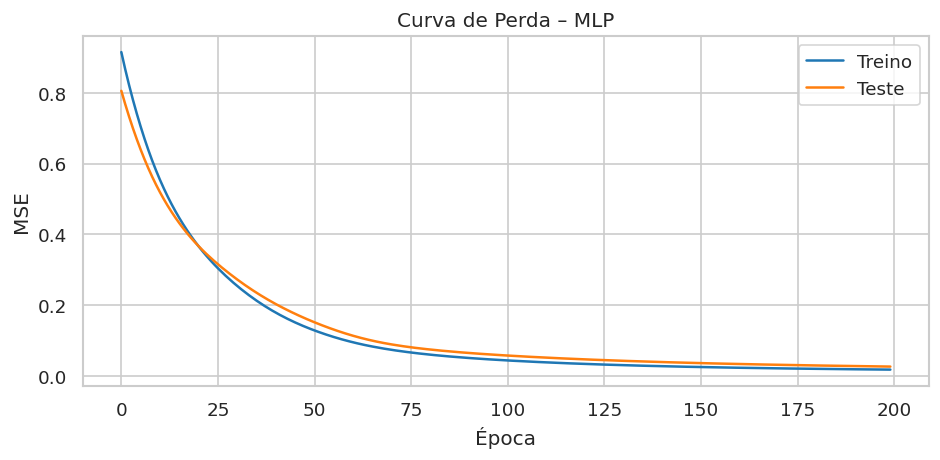

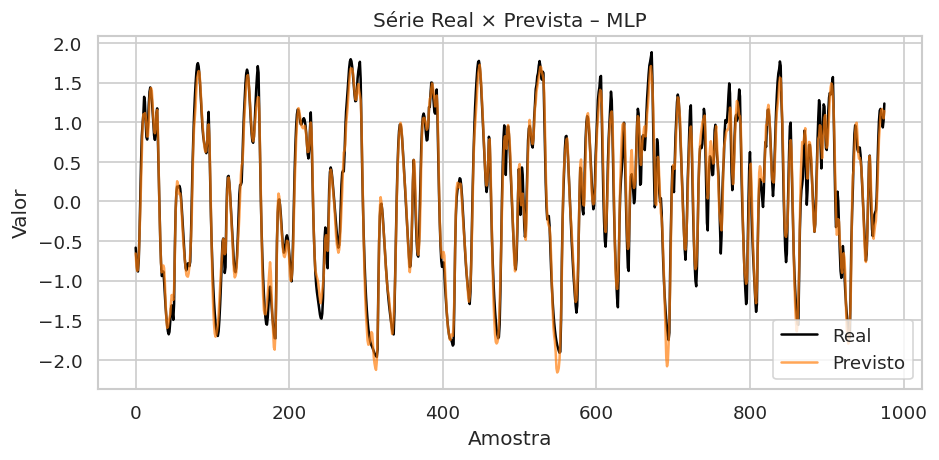

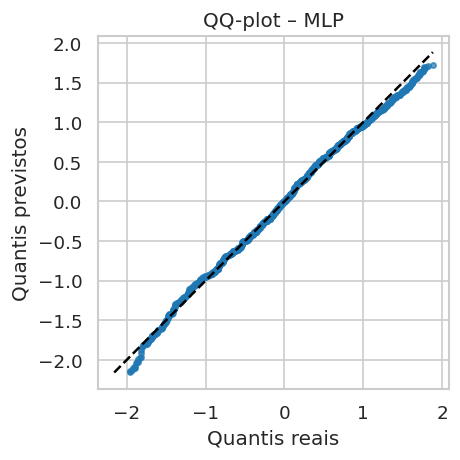

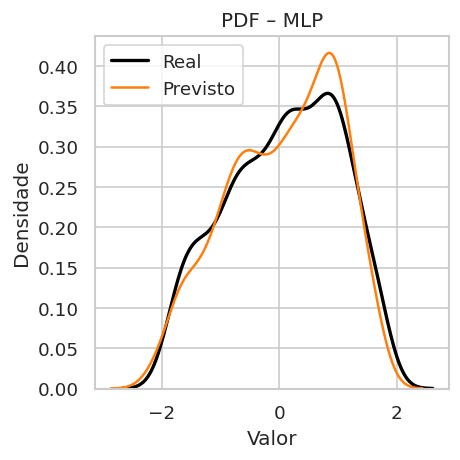

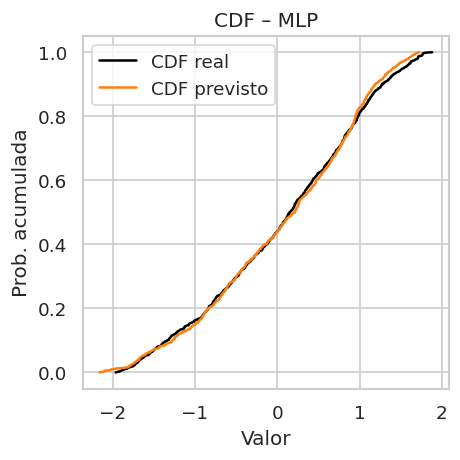

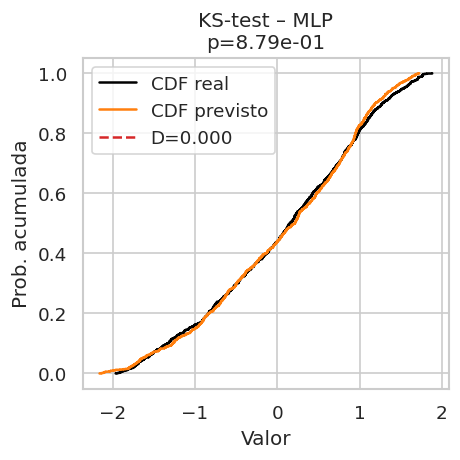

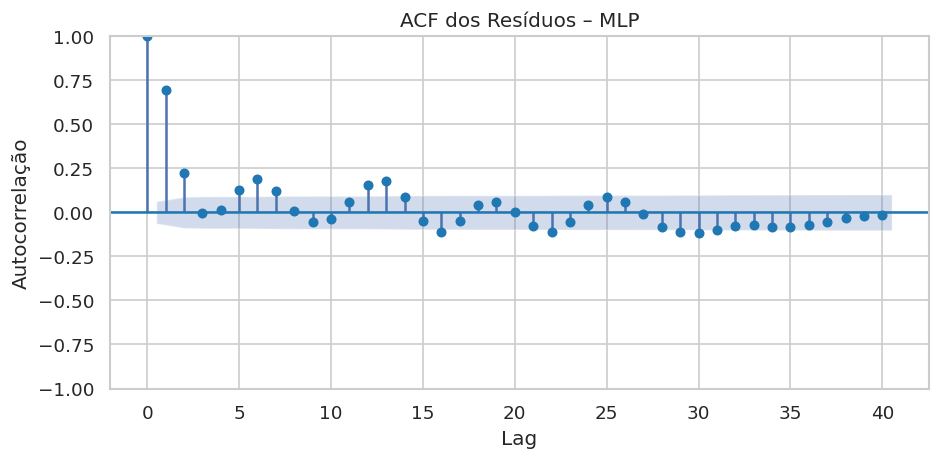

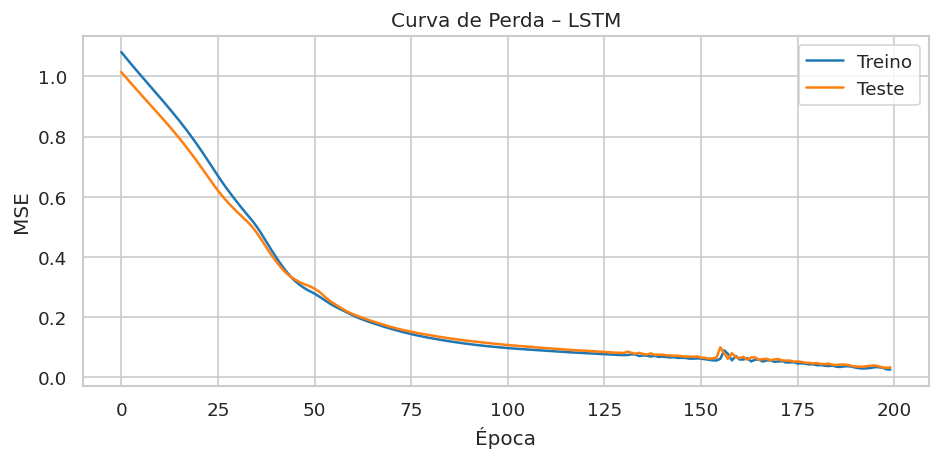

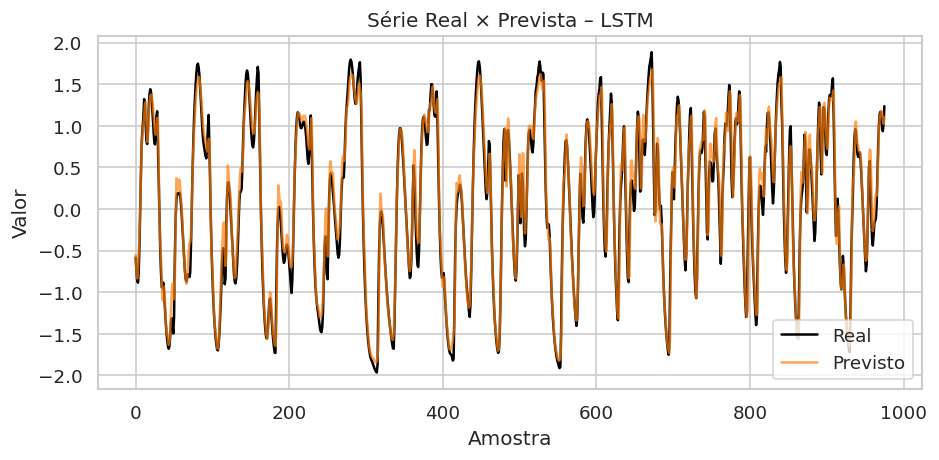

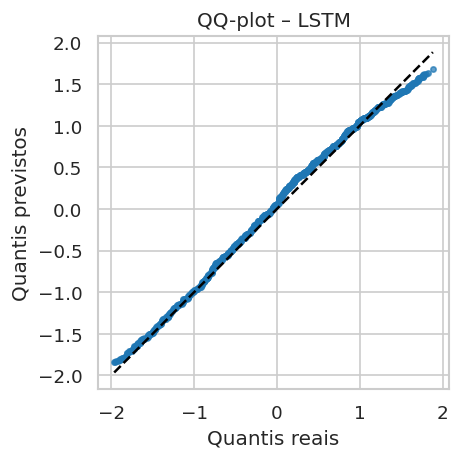

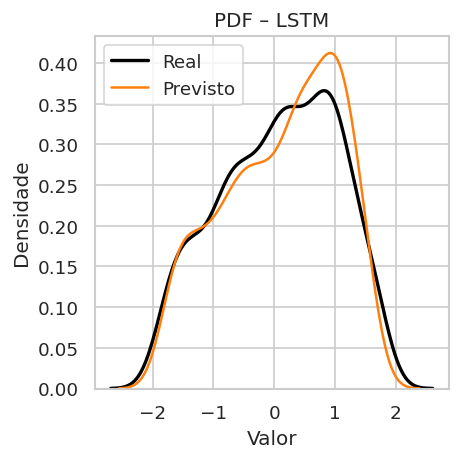

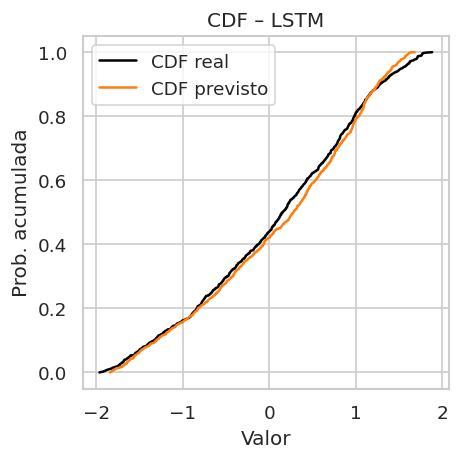

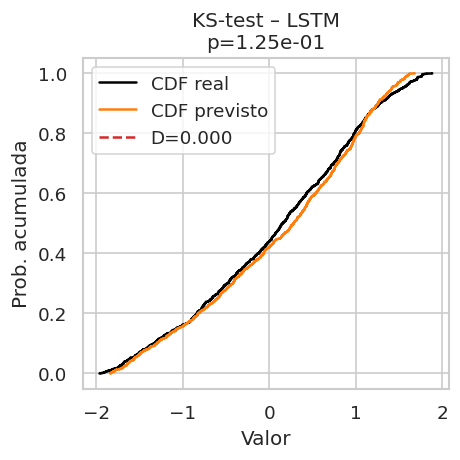

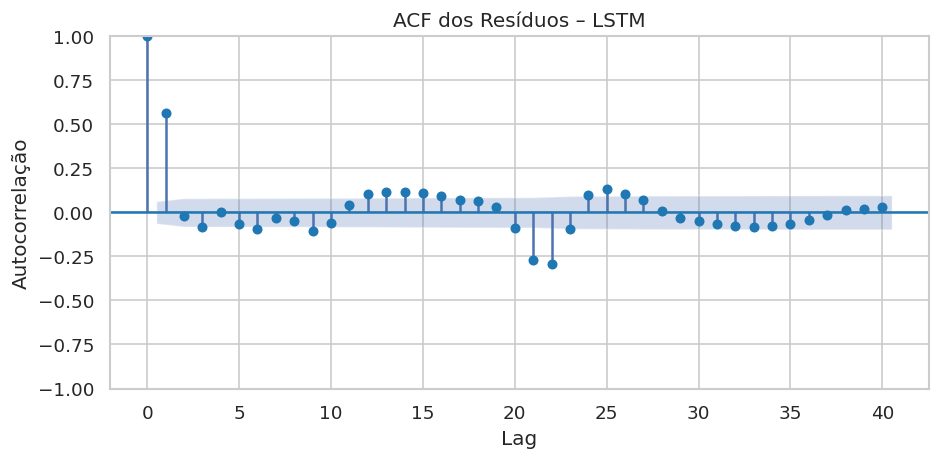

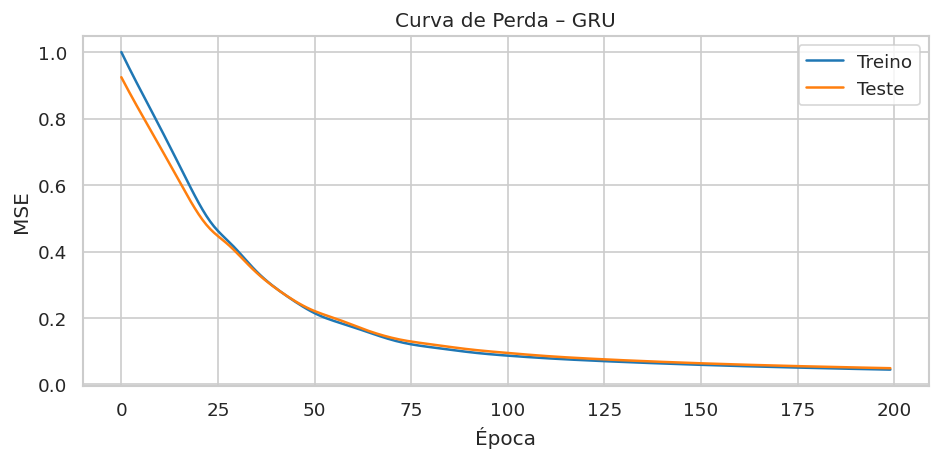

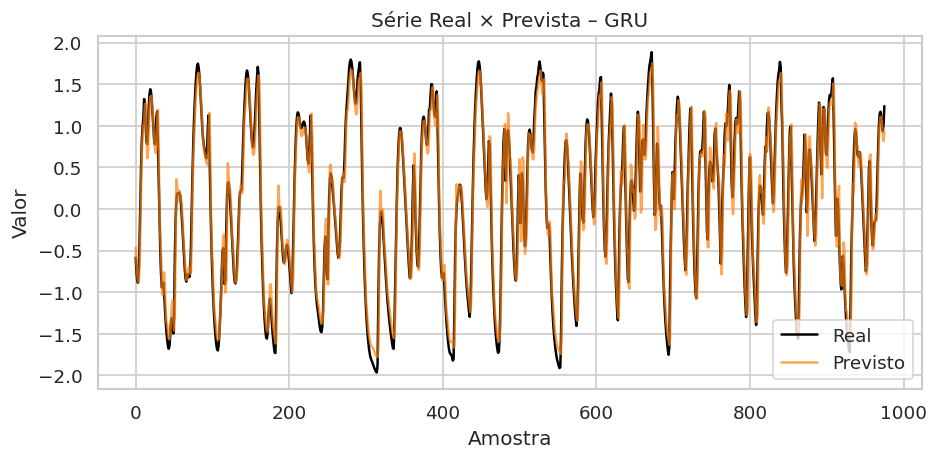

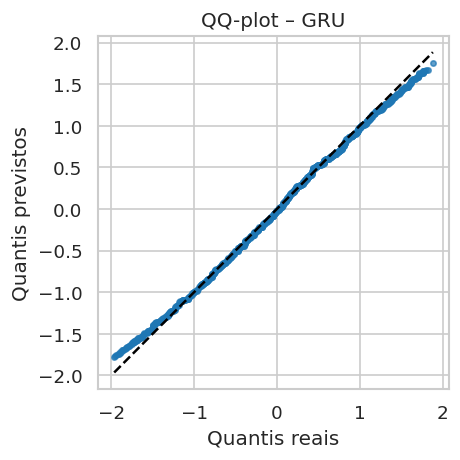

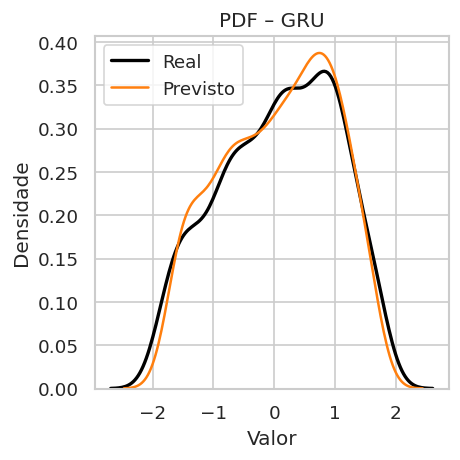

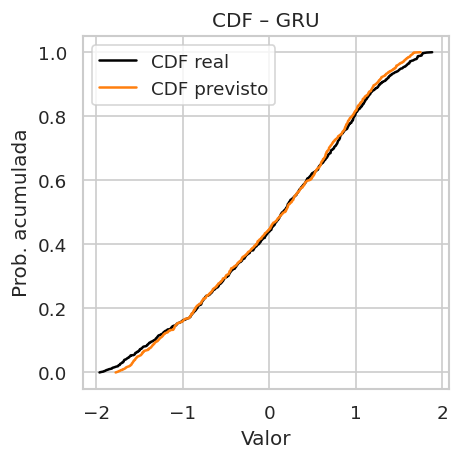

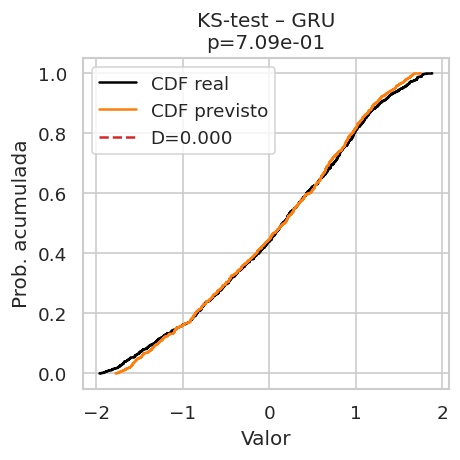

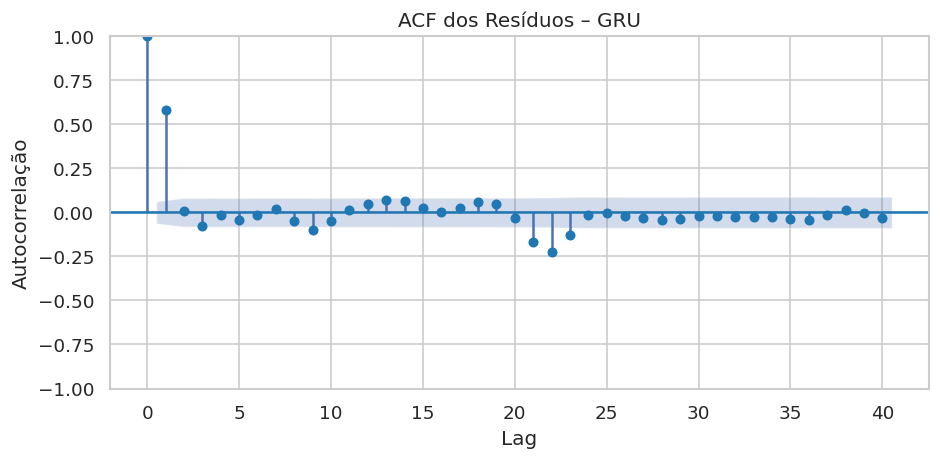

In [124]:
import os, shutil, zipfile
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
from statsmodels.graphics.tsaplots import plot_acf

OUT_DIR = "figs"
if os.path.exists(OUT_DIR):
    shutil.rmtree(OUT_DIR)
os.makedirs(OUT_DIR, exist_ok=True)

# --- alvo real alinhado ------------------------------------------------------
pred_len            = len(preds_mlp_seq)          # mesmo tamanho p/ todos
target_seq_aligned  = serie_norm[split_idx : split_idx + pred_len]

def style_axes(ax, xlabel="", ylabel=""):
    ax.set_xlabel(xlabel); ax.set_ylabel(ylabel); ax.grid(True)

def qqplot_manual(y_true, y_pred, ax):
    qt, qp = np.sort(y_true), np.sort(y_pred)
    n = min(len(qt), len(qp))
    ax.scatter(qt[:n], qp[:n], s=10, color="tab:blue", alpha=.7)
    lims = [min(qt[0], qp[0]), max(qt[-1], qp[-1])]
    ax.plot(lims, lims, "--", color="black")
    style_axes(ax, "Quantis reais", "Quantis previstos")

def plot_model_figures(model_name, hist_tr, hist_te, y_true, y_pred):
    today = datetime.now().strftime("%Y%m%d")

    # 1) Curva de perda --------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(hist_tr, label="Treino",  color="tab:blue")
    ax.plot(hist_te, label="Teste",   color="tab:orange")
    style_axes(ax, "Época", "MSE")
    ax.set_title(f"Curva de Perda – {model_name}")
    ax.legend(); fig.tight_layout()
    fig.savefig(f"{OUT_DIR}/{model_name}_loss_{today}.png", dpi=300)
    plt.show(); plt.close(fig)

    # 2) Série real × prevista (alinhada) -------------------------------------
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(y_true, label="Real",     color="black", linewidth=1.5)
    ax.plot(y_pred, label="Previsto", color="tab:orange", alpha=.7)
    style_axes(ax, "Amostra", "Valor")
    ax.set_title(f"Série Real × Prevista – {model_name}")
    ax.legend(); fig.tight_layout()
    fig.savefig(f"{OUT_DIR}/{model_name}_pred_{today}.png", dpi=300)
    plt.show(); plt.close(fig)

    # 3) QQ-plot --------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(4,4))
    qqplot_manual(y_true, y_pred, ax)
    ax.set_title(f"QQ-plot – {model_name}")
    fig.tight_layout()
    fig.savefig(f"{OUT_DIR}/{model_name}_qq_{today}.png", dpi=300)
    plt.show(); plt.close(fig)

    # 4) PDF (KDE) ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(4,4))
    sns.kdeplot(y_true,  color="black",     label="Real",     ax=ax, linewidth=2)
    sns.kdeplot(y_pred,  color="tab:orange", label="Previsto", ax=ax)
    style_axes(ax, "Valor", "Densidade")
    ax.set_title(f"PDF – {model_name}")
    ax.legend(); fig.tight_layout()
    fig.savefig(f"{OUT_DIR}/{model_name}_pdf_{today}.png", dpi=300)
    plt.show(); plt.close(fig)

    # 5) CDF ------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(4,4))
    ax.plot(np.sort(y_true),
            np.linspace(0,1,len(y_true),endpoint=False),
            label="CDF real",     color="black")
    ax.plot(np.sort(y_pred),
            np.linspace(0,1,len(y_pred),endpoint=False),
            label="CDF previsto", color="tab:orange")
    style_axes(ax, "Valor", "Prob. acumulada")
    ax.set_title(f"CDF – {model_name}")
    ax.legend(); fig.tight_layout()
    fig.savefig(f"{OUT_DIR}/{model_name}_cdf_{today}.png", dpi=300)
    plt.show(); plt.close(fig)

    # 6) KS-test --------------------------------------------------------------
    ecdf_y    = np.linspace(0,1,len(y_true),endpoint=False)
    ecdf_pred = np.linspace(0,1,len(y_pred),endpoint=False)
    idx       = np.argmax(np.abs(ecdf_y - ecdf_pred))
    D_x       = 0.5*(np.sort(y_true)[idx] + np.sort(y_pred)[idx])
    D         = np.abs(ecdf_y[idx] - ecdf_pred[idx])
    p_value   = ks_2samp(y_true, y_pred).pvalue

    fig, ax = plt.subplots(figsize=(4,4))
    ax.step(np.sort(y_true), ecdf_y,    where="post", label="CDF real",     color="black")
    ax.step(np.sort(y_pred), ecdf_pred, where="post", label="CDF previsto", color="tab:orange")
    ax.axvline(D_x, ymin=min(ecdf_y[idx],ecdf_pred[idx]), ymax=max(ecdf_y[idx],ecdf_pred[idx]),
               color="tab:red", linestyle="--", label=f"D={D:.3f}")
    style_axes(ax, "Valor", "Prob. acumulada")
    ax.set_title(f"KS-test – {model_name}\np={p_value:.2e}")
    ax.legend(); fig.tight_layout()
    fig.savefig(f"{OUT_DIR}/{model_name}_kstest_{today}.png", dpi=300)
    plt.show(); plt.close(fig)

    # 7) ACF dos resíduos ------------------------------------------------------
    residuals = y_true - y_pred
    fig = plt.figure(figsize=(8,4))
    plot_acf(residuals, lags=40, ax=plt.gca(), color="tab:blue")
    plt.title(f"ACF dos Resíduos – {model_name}")
    plt.xlabel("Lag"); plt.ylabel("Autocorrelação"); plt.grid(True)
    plt.tight_layout()
    fig.savefig(f"{OUT_DIR}/{model_name}_acf_{today}.png", dpi=300)
    plt.show(); plt.close(fig)

# ─── Gerar figuras com alvo alinhado ─────────────────────────────────────────
plot_model_figures("MLP",  hist_mlp_tr,  hist_mlp_te,  target_seq_aligned, preds_mlp_seq)
plot_model_figures("LSTM", hist_lstm_tr, hist_lstm_te, target_seq_aligned, preds_lstm_seq)
plot_model_figures("GRU",  hist_gru_tr,  hist_gru_te,  target_seq_aligned, preds_gru_seq)

## 7.2 Figuras comparativas dos modelos

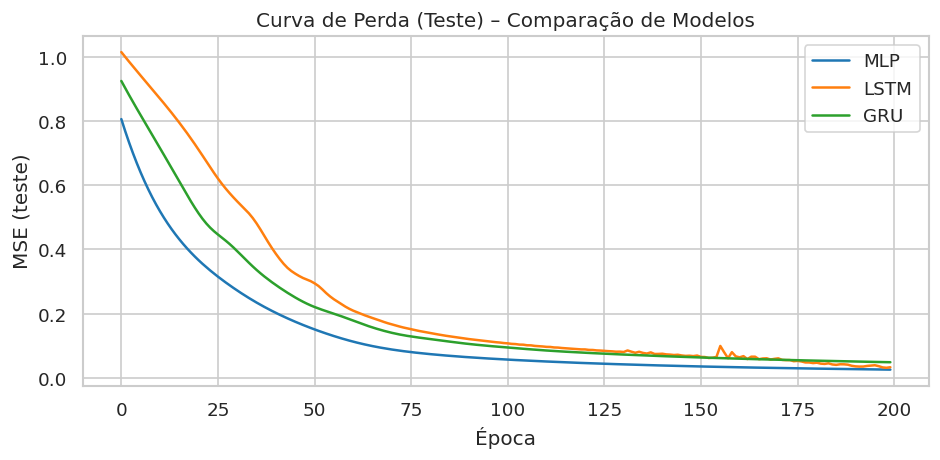

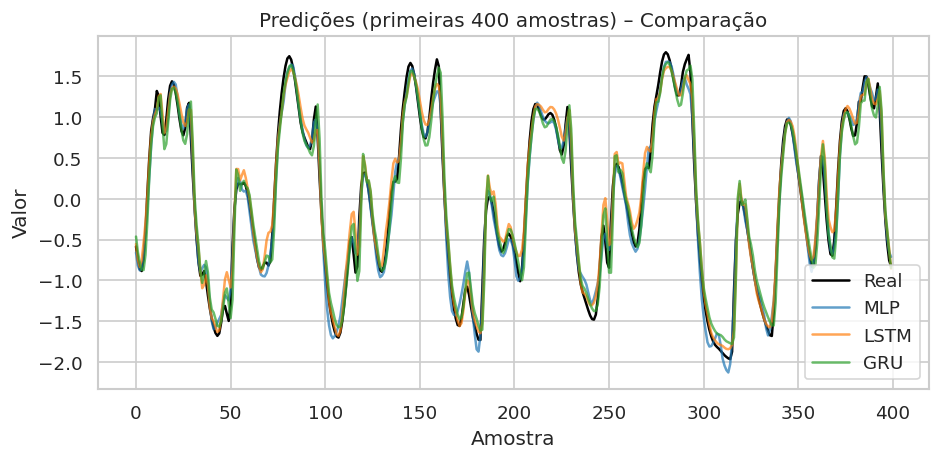

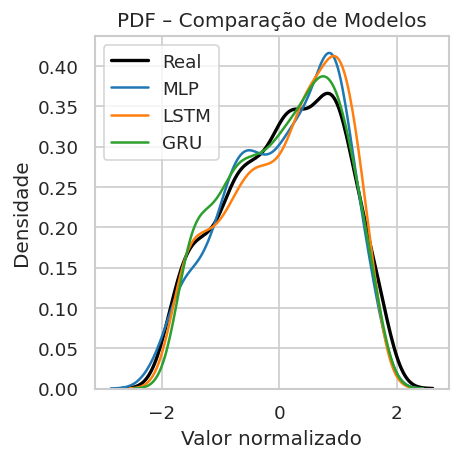

Painéis comparativos salvos em 'figs' e incluídos no figs.zip.


In [125]:
import os, seaborn as sns, matplotlib.pyplot as plt
from datetime import datetime

OUT_DIR = "figs"
today   = datetime.now().strftime("%Y%m%d")

# 1) Perda (teste) ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(hist_mlp_te,  label="MLP",  color="tab:blue")
ax.plot(hist_lstm_te, label="LSTM", color="tab:orange")
ax.plot(hist_gru_te,  label="GRU",  color="tab:green")
ax.set_xlabel("Época"); ax.set_ylabel("MSE (teste)")
ax.set_title("Curva de Perda (Teste) – Comparação de Modelos")
ax.grid(True); ax.legend()
fig.tight_layout()
fig.savefig(f"{OUT_DIR}/loss_cmp_{today}.png", dpi=300)
plt.show(); plt.close(fig)

# 2) Predições (janela de 400 amostras) --------------------------------------
idx0, idx1 = 0, 400
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(target_seq_aligned[idx0:idx1],         label="Real", color="black", linewidth=1.5)
ax.plot(preds_mlp_seq[idx0:idx1],  label="MLP",  color="tab:blue",   alpha=.7)
ax.plot(preds_lstm_seq[idx0:idx1], label="LSTM", color="tab:orange", alpha=.7)
ax.plot(preds_gru_seq[idx0:idx1],  label="GRU",  color="tab:green",  alpha=.7)
ax.set_xlabel("Amostra"); ax.set_ylabel("Valor")
ax.set_title(f"Predições (primeiras {idx1} amostras) – Comparação")
ax.grid(True); ax.legend()
fig.tight_layout()
fig.savefig(f"{OUT_DIR}/pred_cmp_{today}.png", dpi=300)
plt.show(); plt.close(fig)

# 3) PDF (KDE) ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(4,4))
sns.kdeplot(target_seq_aligned, color="black", linewidth=2, label="Real",  ax=ax)
sns.kdeplot(preds_mlp_seq,      color="tab:blue",   label="MLP",           ax=ax)
sns.kdeplot(preds_lstm_seq,     color="tab:orange", label="LSTM",          ax=ax)
sns.kdeplot(preds_gru_seq,      color="tab:green",  label="GRU",           ax=ax)
ax.set_xlabel("Valor normalizado"); ax.set_ylabel("Densidade")
ax.set_title("PDF – Comparação de Modelos")
ax.grid(True); ax.legend()
fig.tight_layout()
fig.savefig(f"{OUT_DIR}/pdf_cmp_{today}.png", dpi=300)
plt.show(); plt.close(fig)

print(f"Painéis comparativos salvos em '{OUT_DIR}' e incluídos no figs.zip.")

## 7.3 Baixar imagens

In [126]:
# ─── Compactar e disponibilizar download -------------------------------------
shutil.make_archive("figs", "zip", OUT_DIR)
print("Arquivo figs.zip criado em", os.getcwd())

# Comente a linha abaixo para não baixar automaticamente as imagens
from google.colab import files; files.download("figs.zip")

Arquivo figs.zip criado em /content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>